# Credit Card Transaction Fraud Detection with Labeled Data

This project tries to find out fraud in credit card transaction. This is a supervised learning.

The dataset is from kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

Some insight about the dataset (from Kaggle):
    "The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."



Approach:

    - Exploratory Data Analysis (EDA) to understand the data.
    - Explore three outlier detection algorithms from scikit learn libaries

The dataset is already feature engineered with PCA. We tried to see if there was a missing value or feauture distribution of the dataset. This is a highly unbalanced dataset which is very normal for outlier/ fraud detection dataset. Afterall, frauds are not normal; they are exceptions and thus outliers.



In [39]:
# importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [40]:
# importing three classification algorithms from sklearn

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score


In [90]:
#reading the dataset
df = pd.read_csv('data/creditcard.csv', sep=',')

In [92]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


From the above, we can see that out of 31 features, 'Time', 'Amount' and 'Class' are original values and rest are PCA components of the original data (labeled as V1 to V28). 

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

We can see that there is not much space for feature engineering with this dataset.

In [94]:
# Checking for missing values
df.isnull().values.any()

False

Text(0, 0.5, 'Transaction count')

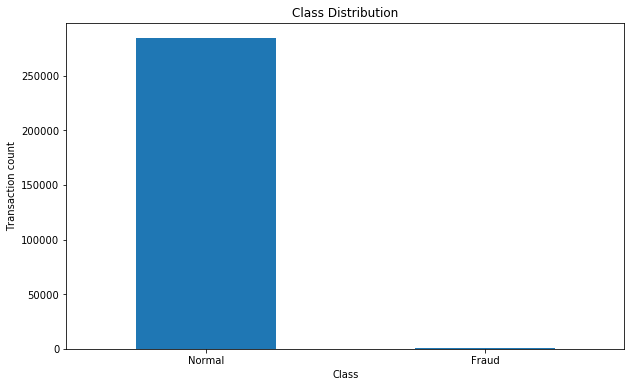

In [47]:
# We make a count of the classes for normal and fraudulent transaction
count_class = pd.value_counts(df['Class'], sort= True)

#plotting the class distribution
plt.figure(figsize=(10,6))
labels= ['Normal', 'Fraud']
count_class.plot(kind='bar', rot = 0)
plt.title("Class Distribution")
plt.xticks(range(2),labels)
plt.xlabel('Class')
plt.ylabel('Transaction count')


In [95]:
# Making two separate datasets for easy visualization of normal and fraud transaction

valid_transaction = df[df['Class']==0]

fraud_transaction = df[df['Class']==1]

In [96]:
valid_transaction.shape, fraud_transaction.shape

((284315, 31), (492, 31))

In [97]:
# Getting an idea about the fraud transaction amounts

fraud_transaction.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

From above, we can see that about 25% of fraudulent transaction had only amounting $1. Maximum amount is $2125. In general, only low amount is transacted with fruadulent activities.

In [98]:
# Getting an idea about the valid transaction amounts

valid_transaction.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [ ]:
# Plotting the amount vs transaction

figures, (ax1, ax2) = plt.subplots(2,1, sharex = True)

figures.suptitle('Amount per Transaction by Valid and Fraud')

ax1.hist(fraud_transaction, bins = 'auto')
ax1.set_title("Fraud")
ax2.hist(valid_transaction, bins = 'auto')
ax2.set_title("Valid")

plt.xlabel("Amount in $")
plt.ylabel("Number of Transaction")
plt.xlim(0, 25000)
plt.yscale('log')

Text(0, 0.5, 'Amount')

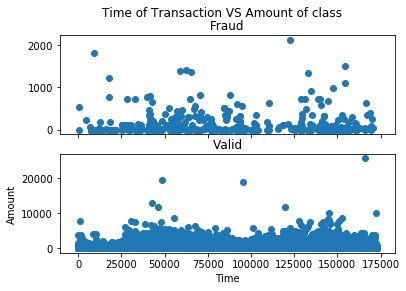

In [110]:

figures, (ax1, ax2) = plt.subplots(2,1, sharex = True)

figures.suptitle('Time of Transaction VS Amount of class')

ax1.scatter(fraud_transaction.Time, fraud_transaction.Amount)
ax1.set_title("Fraud")
ax2.scatter(valid_transaction.Time, valid_transaction.Amount)
ax2.set_title("Valid")

plt.xlabel("Time")
plt.ylabel("Amount")


In [66]:
# taking 10% of the data for quick computation
df_frac = df.sample(frac=0.1, random_state = 1)
df_frac.shape


(28481, 31)

In [67]:
# Looking at the class variation in the fractioned dataset

fraud_frac = df_frac[df_frac['Class']== 1]

valid_frac = df_frac[df_frac['Class']== 0]

outlier_fraction = (len(fraud_frac))/ len(valid_frac)

In [68]:
len(fraud_frac)

49

In [69]:
print(outlier_fraction)
print('\n')
print("Fraud Transactions {}".format(len(fraud_frac)))
print('\n')
print("Valid Transactions {}".format(len(valid_frac)))

0.0017234102419808666
Fraud Transactions 49


Valid Transactions 28432


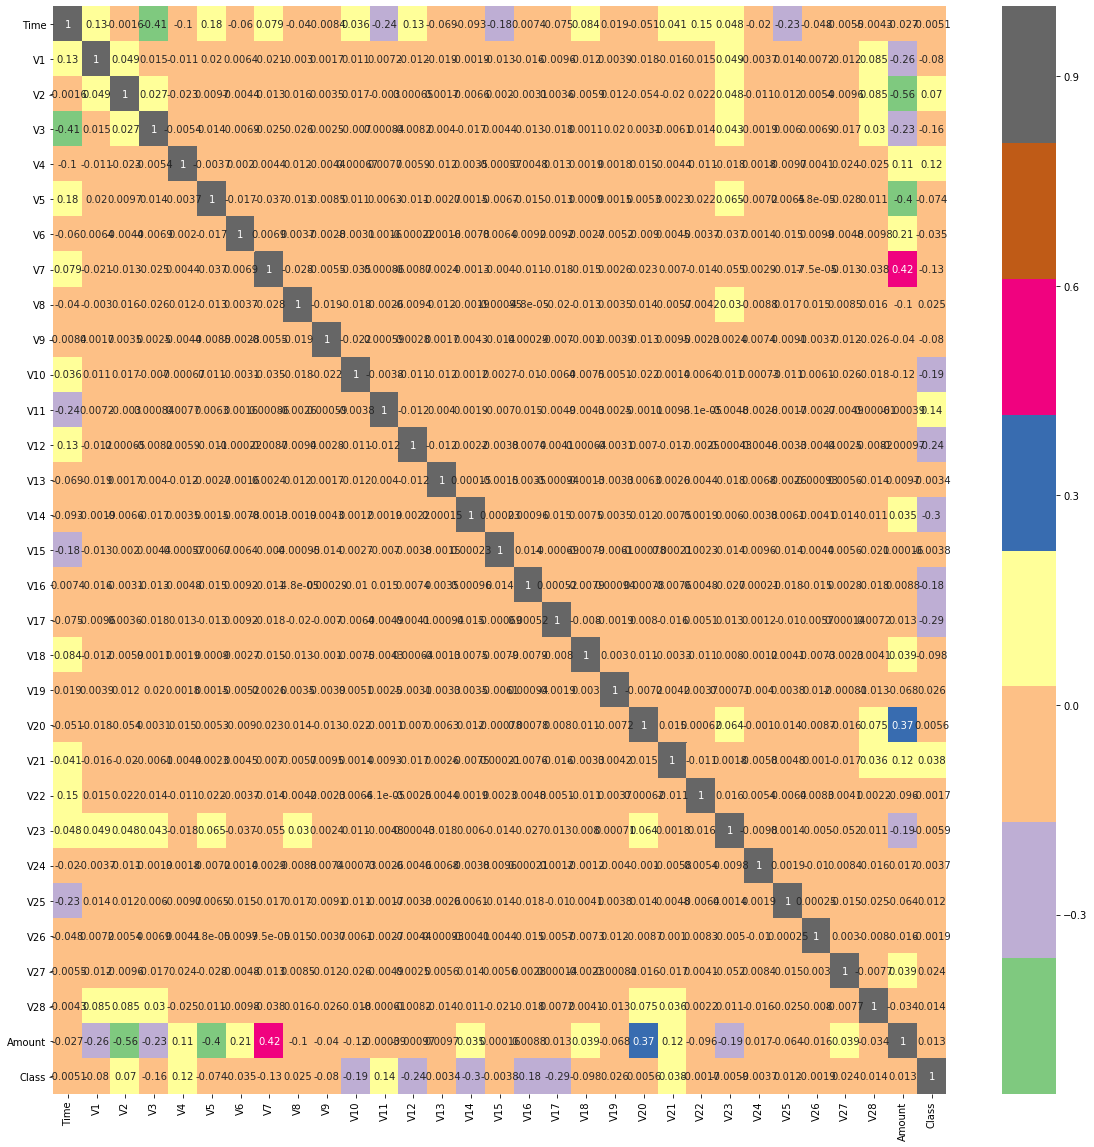

In [71]:
# Heatmap to visualize the correlation

correlation_matrix = df_frac.corr()

correlation_features = correlation_matrix.index

plt.figure(figsize= (20,20))

sns.heatmap(df_frac[correlation_features].corr(), annot=True, cmap='Accent')


In [80]:
# creating training and test data

columns = df_frac.columns.tolist()
columns = [c for c in columns if c not in 'Class']

target = 'Class'

state = np.random.RandomState(42)
X = df_frac[columns]
y = df_frac[target]

X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

In [84]:
X.shape, y.shape

numpy.ndarray

In [87]:
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators= 100, max_samples= len(X), 
                                        contamination=outlier_fraction, random_state= state, verbose = 0),
    
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma = 0.1, nu=0.05, 
                                          max_iter=-1, random_state=state)
}

In [89]:
n_outliers = len(fraud_frac)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    if clf_name == 'Local Outlier Factor':
        y_pred = clf.fit_predict(X)
        score_prediction = clf.negative_outlier_factor_
    elif clf_name == 'Suppor Vector Machine':
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        score_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
        
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))

        
        

/Users/mokul791/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 8516
Accuracy Score :
0.7009936448860644
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70   

It is evident from the above that Isolation Forest performs better than other classifier